# Visualization of the computational experiment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from constants.constants import RESULTS_FILE, RESULTS_BACKUP_FILE

### Fetching the results file

In [2]:
column_names = [
    'NumProducts',
    'Run',
    'Approach',
    'Time',
    'OptValue',
    'C',
    'ClingoStats_Constraints',
    'ClingoStats_Complexity',
    'ClingoStats_Vars',
    'ClingoStats_Atoms',
    'ClingoStats_Bodies',
    'ClingoStats_Rules',
    'ClingoStats_Choices',
    'ClingoStats_Conflicts',
    'ClingoStats_Restarts',
    'ClingoStats_Models',
    'Variables',
    'Constraints',
    'Timeout'
]

In [3]:
df = pd.read_csv(RESULTS_FILE, names=column_names)
df = df.sort_values(by=['NumProducts', 'Run', 'Approach'])
df[['NumProducts', 'Run', 'Approach', 'Time', 'OptValue', 'C', 'Timeout']]

,NumProducts,Run,Approach,Time,OptValue,C,Timeout
169,6,0,asp,0.389848,480.0,480,NaN
180,6,0,bad,0.037652,480.0,480,NaN
80,6,0,concorde,0.084202,NaN,480,NaN
243,6,0,ilp,0.287732,NaN,480,NaN
215,6,0,pddl,0.209738,480.0,480,NaN
...,...,...,...,...,...,...,...
162,46,3,concorde,0.297750,NaN,2745,NaN
165,48,0,concorde,0.179315,NaN,2865,NaN
164,48,1,concorde,0.172548,NaN,2895,NaN
167,48,2,concorde,0.216251,NaN,2715,NaN


### Get Approaches, Runs and NumProducts

In [4]:
approaches = df['Approach'].drop_duplicates().to_list()
approaches

['asp', 'bad', 'concorde', 'ilp', 'pddl', 'tsp']

In [5]:
runs = df['Run'].drop_duplicates().to_list()
runs

[0, 1, 2, 3]

In [6]:
numProducts = df['NumProducts'].drop_duplicates().to_list()
numProducts

[6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48]

### Check data sanity

In [7]:
for numProduct in numProducts:
    for run in runs:
        df_temp_numProduct = df[df['NumProducts'] == numProduct]
        df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
        df_temp_run_woT = df_temp_run[df_temp_run['Timeout'] == False]
        if len(df_temp_run_woT['C'].drop_duplicates().to_list()) > 1:
            print('ERROR')
            print(f'numProduct: {numProduct} run: {run}')
            print(df_temp_run_woT[['Approach', 'C']])
            print()

### Preprocessing the data for plotting

In [8]:
metrics = {
    'Time': 'Computation time (in sec)',
    'ClingoStats_Constraints': 'Number of constraints (clingo)',
    'ClingoStats_Complexity': 'Degree of complexity (clingo)',
    'ClingoStats_Vars': 'Number of variables (clingo)',
    'ClingoStats_Atoms': 'Number of atoms (clingo)',
    'ClingoStats_Bodies': 'Number of bodies (clingo)',
    'ClingoStats_Rules': 'Number of rules (clingo)',
    'ClingoStats_Choices': 'Number of choices (clingo)',
    'ClingoStats_Conflicts': 'Number of conflicts (clingo)',
    'ClingoStats_Restarts': 'Number of restarts (clingo)',
    'ClingoStats_Models': 'Number of models (clingo)',
    'Variables': 'Number of variables (docplex)',
    'Constraints': 'Number of constraints (docplex)'
}

In [9]:
data = {}
for approach in approaches:
    df_approach = df[df['Approach'] == approach]
    
    data[approach] = {}
    for metric in metrics:
        data[approach][metric] = {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []}
    
        for numProduct in numProducts:
            df_numProduct = df_approach[df_approach['NumProducts'] == numProduct]
            if metric != 'Time':
                df_numProduct = df_numProduct[df_numProduct['Timeout'] == False]
            
            if not df_numProduct.empty:
                values = df_numProduct[metric].to_list()
                lb = min(values)
                ub = max(values)
                mean = float(sum(values)) / len(values)
                if not pd.isna(mean):
                    data[approach][metric]['lbs'].append(lb)
                    data[approach][metric]['ubs'].append(ub)
                    data[approach][metric]['means'].append(mean)
                    data[approach][metric]['numProducts'].append(numProduct)

## Creating plots

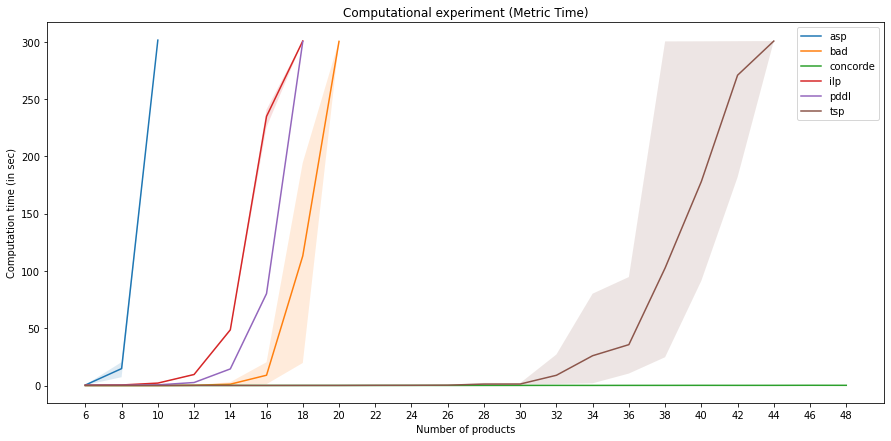

No handles with labels found to put in legend.


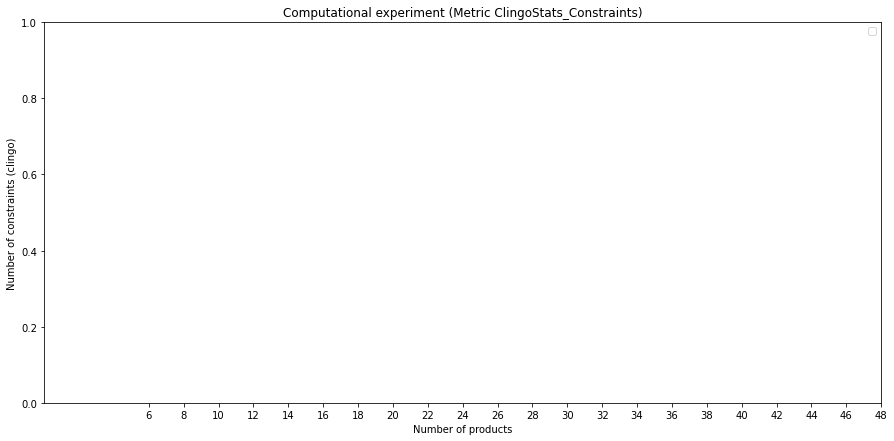

No handles with labels found to put in legend.


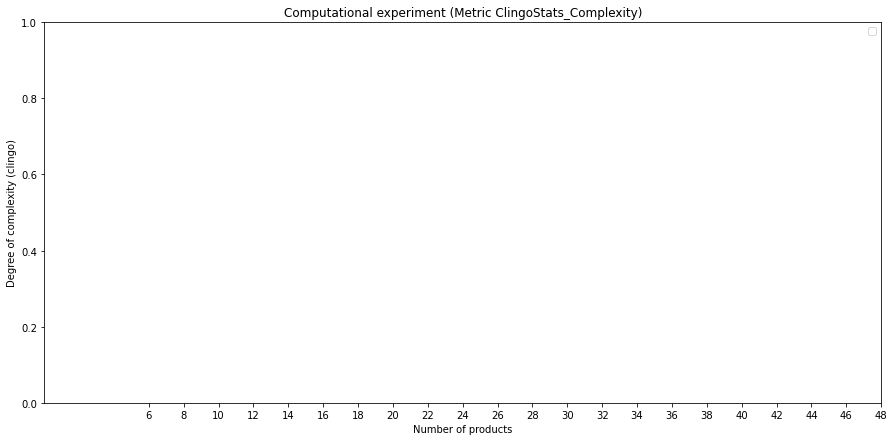

No handles with labels found to put in legend.


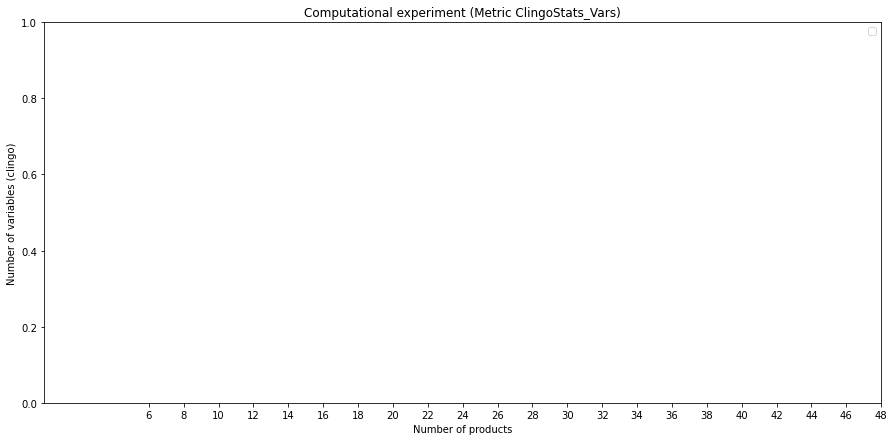

No handles with labels found to put in legend.


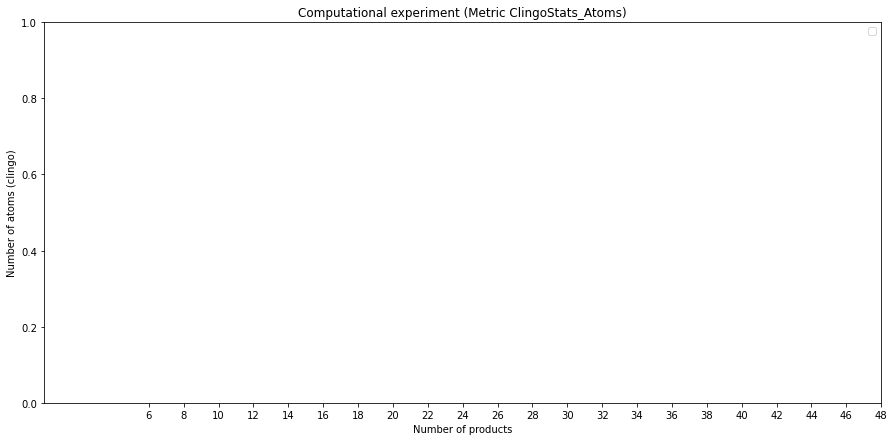

No handles with labels found to put in legend.


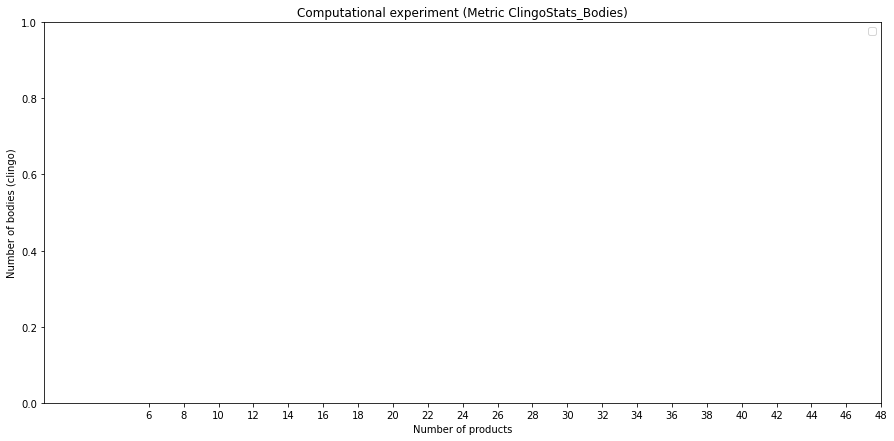

No handles with labels found to put in legend.


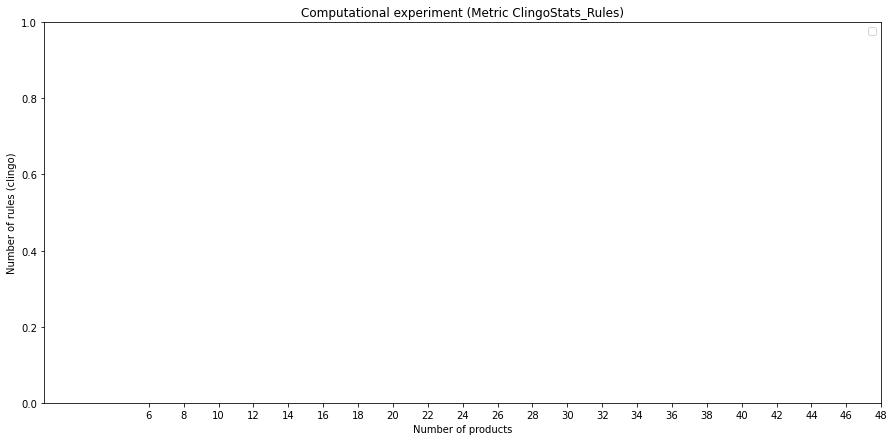

No handles with labels found to put in legend.


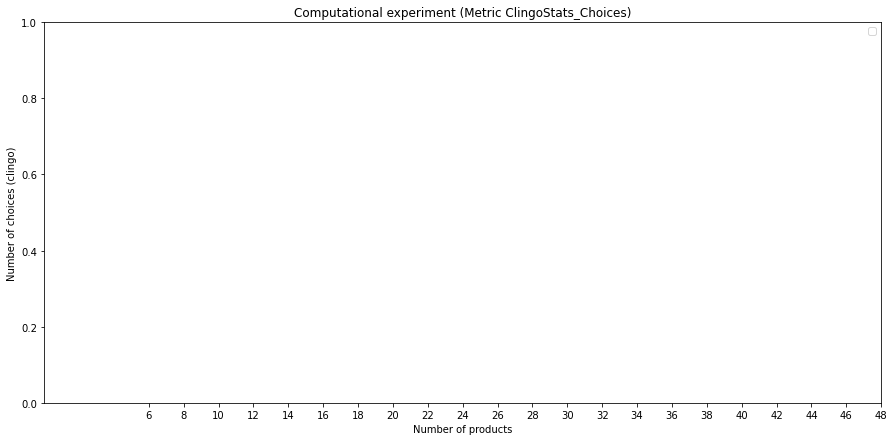

No handles with labels found to put in legend.


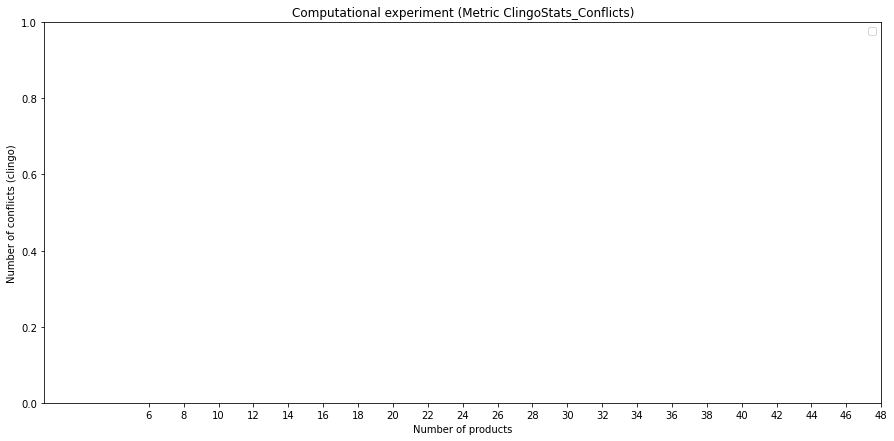

No handles with labels found to put in legend.


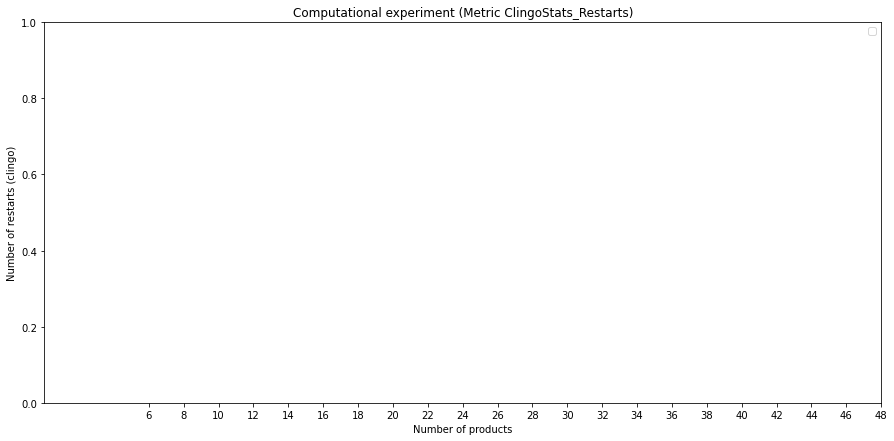

No handles with labels found to put in legend.


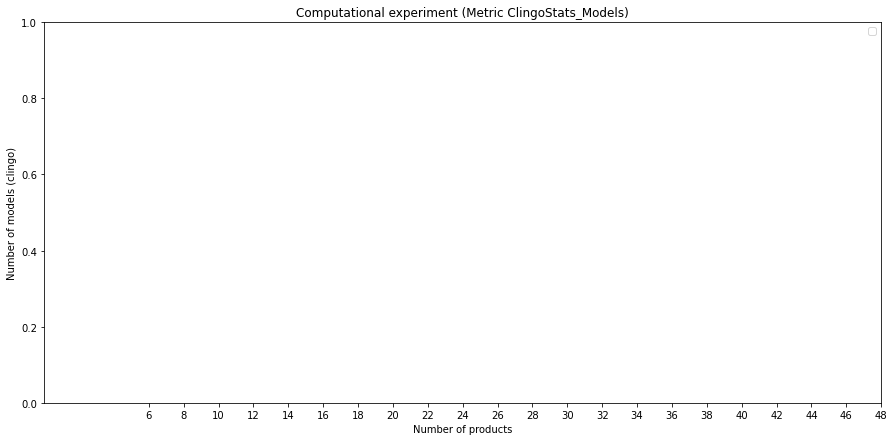

No handles with labels found to put in legend.


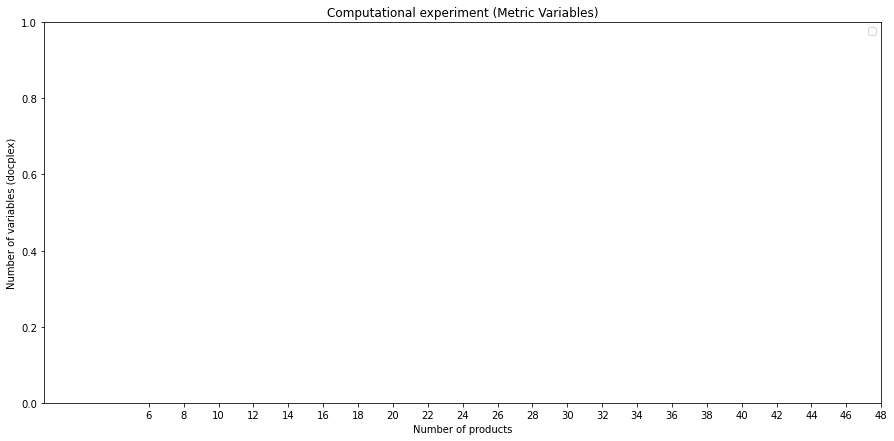

No handles with labels found to put in legend.


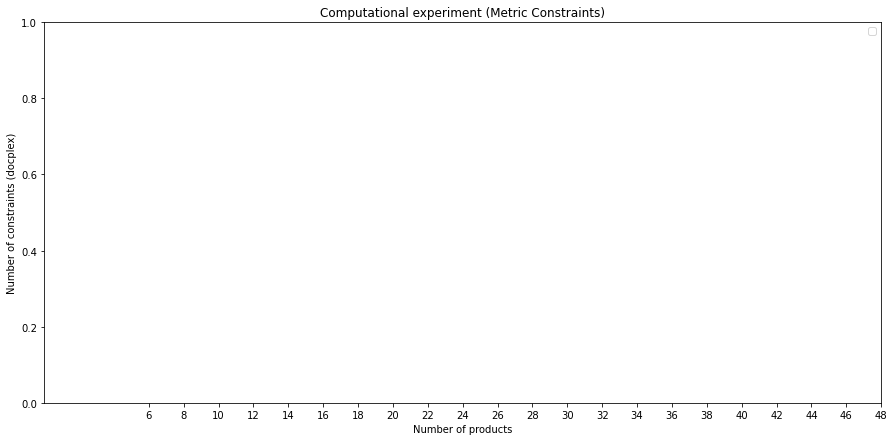

In [10]:
for metric, ylabel in metrics.items():
    plt.figure(figsize=(15, 7))
    plt.title(f'Computational experiment (Metric {metric})')
    plt.xticks(numProducts)
    plt.xlabel('Number of products')
    plt.ylabel(ylabel)

    for approach in approaches:
        if len(data[approach][metric]['numProducts']) > 0:
            plt.plot(data[approach][metric]['numProducts'], data[approach][metric]['means'], label=approach)
            plt.fill_between(data[approach][metric]['numProducts'], data[approach][metric]['lbs'], data[approach][metric]['ubs'], alpha=0.15)

    plt.legend()
    plt.show()